In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# Function to identify log phase growth
def identify_log_phase(well_data, min_growth_rate=0.2, min_duration_hours=.5):
    """
    Identify log phase growth period for a well.
    
    Parameters:
    - well_data: DataFrame with time_hours and cell_concentration_cells_per_ml
    - min_growth_rate: Minimum growth rate (doubling per hour) to consider as log phase
    - min_duration_hours: Minimum duration in hours for a log phase period
    
    Returns:
    - Dictionary with log phase information
    """
    well_data = well_data.sort_values('time_hours')
    
    # Calculate growth rate (doubling time)
    well_data['growth_rate'] = np.log(well_data['cell_concentration_cells_per_ml'] / well_data['cell_concentration_cells_per_ml'].shift(1)) / (well_data['time_hours'] - well_data['time_hours'].shift(1))
    
    # Find periods of consistent positive growth
    log_phase_periods = []
    current_period_start = None
    
    for i, row in well_data.iterrows():
        if pd.isna(row['growth_rate']):
            continue
            
        if row['growth_rate'] >= min_growth_rate:
            if current_period_start is None:
                current_period_start = i
        else:
            if current_period_start is not None:
                # End of current period
                period_duration = well_data.loc[i, 'time_hours'] - well_data.loc[current_period_start, 'time_hours']
                if period_duration >= min_duration_hours:
                    log_phase_periods.append({
                        'start_time': well_data.loc[current_period_start, 'time_hours'],
                        'end_time': well_data.loc[i, 'time_hours'],
                        'duration_hours': period_duration,
                        'start_concentration': well_data.loc[current_period_start, 'cell_concentration_cells_per_ml'],
                        'end_concentration': well_data.loc[i, 'cell_concentration_cells_per_ml']
                    })
                current_period_start = None
    
    # Handle case where log phase continues to the end
    if current_period_start is not None:
        period_duration = well_data['time_hours'].iloc[-1] - well_data.loc[current_period_start, 'time_hours']
        if period_duration >= min_duration_hours:
            log_phase_periods.append({
                'start_time': well_data.loc[current_period_start, 'time_hours'],
                'end_time': well_data['time_hours'].iloc[-1],
                'duration_hours': period_duration,
                'start_concentration': well_data.loc[current_period_start, 'cell_concentration_cells_per_ml'],
                'end_concentration': well_data['cell_concentration_cells_per_ml'].iloc[-1]
            })
    
    # Calculate total log phase duration
    total_log_duration = sum(period['duration_hours'] for period in log_phase_periods)
    
    return {
        'well': well_data['well'].iloc[0],
        'total_log_duration_hours': total_log_duration,
        'log_phase_periods': log_phase_periods,
        'max_growth_rate': well_data['growth_rate'].max() if not well_data['growth_rate'].isna().all() else 0
    }

def annotate_wells(results_df):
    ratios = [45/255, 60/240, 120/180, 180/120, 240/60, 270/30]
    results_df['column'] = results_df['well'].astype(str).apply(lambda x: x[1:])
    results_df['row'] = results_df['well'].astype(str).apply(lambda x: x[0])
    results_df['sugar'] = results_df['column'].map({
        "1":"Low","2":"Low","3":"Low","4":"Low","5":"Low","6":"Low",
        "7":"High","8":"High","9":"High","10":"High","11":"High","12":"High",})
    results_df['ratio'] = results_df['column'].map({
        "1":ratios[0],"2":ratios[1],"3":ratios[2],"4":ratios[3],"5":ratios[4],"6":ratios[5],
        "7":ratios[0],"8":ratios[1],"9":ratios[2],"10":ratios[3],"11":ratios[4],"12":ratios[5],})
    return results_df

In [3]:
df = pd.read_csv('Monomer_Test_DO_NOT_USE_cell_concentration_data.csv')
# Convert timestamp to datetime and calculate time in hours
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_hours'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600

df.head()


,timestamp,well,culture_id,cell_concentration_cells_per_ml,absorbance_600nm,time_hours
0,2025-10-25 18:43:57.484330+00:00,A1,CLTR14EVR7MSUOABEG42ANEA4WNVELA,614800000,0.6148,0.000000
1,2025-10-25 19:30:14.600462+00:00,A1,CLTR14EVR7MSUOABEG42ANEA4WNVELA,658000000,0.6580,0.771421
2,2025-10-25 19:34:57.557812+00:00,A1,CLTR14EVR7MSUOABEG42ANEA4WNVELA,656500000,0.6565,0.850020
3,2025-10-25 19:39:53.665317+00:00,A1,CLTR14EVR7MSUOABEG42ANEA4WNVELA,651000000,0.6510,0.932272
4,2025-10-25 19:44:53.454793+00:00,A1,CLTR14EVR7MSUOABEG42ANEA4WNVELA,647500000,0.6475,1.015547


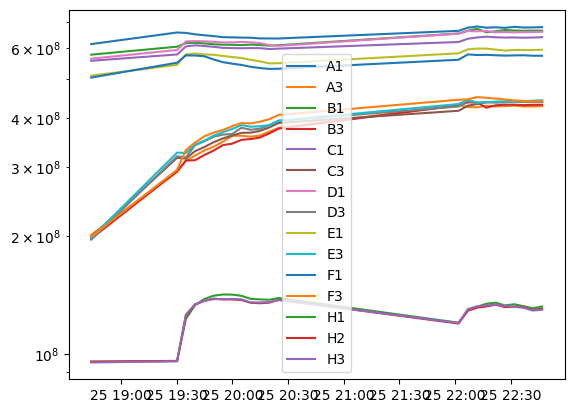

In [4]:
for well in df['well'].unique():
    df_i = df[df['well'] == well]
    plt.plot(df_i['timestamp'], df_i['cell_concentration_cells_per_ml'], label=well)
plt.semilogy()
plt.legend()
plt.show()


In [5]:

# Analyze each well
log_phase_results = []
for well in df['well'].unique():
    well_data = df[df['well'] == well].copy()
    result = identify_log_phase(well_data,min_growth_rate=0.2, min_duration_hours=.5)
    log_phase_results.append(result)

# Create results DataFrame
results_df = pd.DataFrame([
    {
        'well': result['well'],
        'log_phase_duration_hours': result['total_log_duration_hours'],
        'max_growth_rate': result['max_growth_rate'],
        'num_log_periods': len(result['log_phase_periods'])
    }
    for result in log_phase_results
])

print("Log Phase Analysis Results:")
print(results_df.sort_values('log_phase_duration_hours', ascending=False))


Log Phase Analysis Results:
   well  log_phase_duration_hours  max_growth_rate  num_log_periods
1    A3                  2.278454         0.821108                2
9    E3                  2.116185         0.646753                2
3    B3                  1.699834         0.811018                1
5    C3                  1.699834         0.601417                1
7    D3                  1.699834         0.870767                1
11   F3                  1.616142         1.467287                1
13   H2                  1.616142         3.362392                1
0    A1                  0.000000         0.220284                0
2    B1                  0.000000         0.270265                0
4    C1                  0.000000         0.594961                0
6    D1                  0.000000         0.639197                0
8    E1                  0.000000         0.779558                0
10   F1                  0.000000         0.544360                0
12   H1             

In [6]:
results_df_annotated = annotate_wells(results_df)
results_df_annotated[['well','log_phase_duration_hours','sugar','ratio']]

,well,log_phase_duration_hours,sugar,ratio
0,A1,0.000000,Low,0.176471
1,A3,2.278454,Low,0.666667
2,B1,0.000000,Low,0.176471
3,B3,1.699834,Low,0.666667
4,C1,0.000000,Low,0.176471
5,C3,1.699834,Low,0.666667
6,D1,0.000000,Low,0.176471
7,D3,1.699834,Low,0.666667
8,E1,0.000000,Low,0.176471
9,E3,2.116185,Low,0.666667


In [7]:
results_df_annotated.groupby(['column','ratio'])['log_phase_duration_hours'].mean()

column  ratio   
1       0.176471    0.000000
2       0.250000    1.616142
3       0.666667    1.587183
Name: log_phase_duration_hours, dtype: float64

In [8]:
results_df_annotated.groupby(['sugar','ratio'])['log_phase_duration_hours'].mean()

sugar  ratio   
Low    0.176471    0.000000
       0.250000    1.616142
       0.666667    1.587183
Name: log_phase_duration_hours, dtype: float64